## Examining Bandpass stability with UVSPEC
August 10, 2018
D.J. Pisano

This notebook uses the first _X_ minutes of an observation to derive a bandpass calibration and then compares the amplitude and phases over equal length chunks of time throughout the rest of the observation. 


This module will be used to plot bandpass shapes from calibrator data using the Miriad task _uvspec_.  This particular module is designed to look at the variations of the flux of a calibrator using UV data from *all* the antennas/baselines together as this is what affects the final image quality.  

It will compare variations on a short timescale with the solution averaged over the entire observation.  It will make plots of amplitude & phase variations.  

First, we will load apercal and start the log.

In [1]:
import os;
myusername = os.environ['USER']
if not ('PYTHONPATH' in os.environ and
        '/home/' + myusername + '/apercal' in os.environ['PYTHONPATH']):
      print("WARNING: your apercal directory should be in the $PYTHONPATH")

%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/{}/testing/logs/bp_stability_uv.log'.format(myusername))

cfgfile='/home/{}/testing/cfg/bp_stability.cfg'.format(myusername)

import apercal

/home/apercal/pipeline/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/pisano/testing/logs/bp_stability_uv.log


Setup logger with lib.setup_logger()


Now we will calibrate the data to do the BP stability test on.  First we load the data.

In [2]:
prepare = apercal.prepare(cfgfile)
prepare.show(showall=True)

PREPARE - INFO : ### Configuration file /home/pisano/testing/cfg/bp_stability.cfg successfully read! ###


INITIAL
	apercaldir = /home/pisano/apercal
	fluxcal = 3C48.MS
	polcal = 
	target = 
	basedir = /data/pisano/BP/
	beam = 00
	rawsubdir = raw
	crosscalsubdir = crosscal
	selfcalsubdir = selfcal
	linesubdir = line
	contsubdir = continuum
	polsubdir = polarisation
	mossubdir = mosaics
	transfersubdir = transfer
PREPARE
	prepare_obsdir_fluxcal = /data4/apertif/180202013_3C48/
	prepare_obsdir_polcal = 
	prepare_obsdir_target = 
	prepare_obsmode = single_element
PREFLAG
	preflag_manualflag = True
	preflag_manualflag_fluxcal = True
	preflag_manualflag_polcal = False
	preflag_manualflag_target = False
	preflag_manualflag_auto = True
	preflag_manualflag_antenna = RT4
	preflag_manualflag_corr = 
	preflag_manualflag_shadow = True
	preflag_manualflag_baseline = 
	preflag_manualflag_channel = 
	preflag_manualflag_time = 
	preflag_aoflagger = True
	preflag_aoflagger_bandpass = True
	preflag_aoflagger_fluxcal = True
	preflag_aoflagger_polcal = False
	preflag_aoflagger_target = False
	preflag_aoflagger

In [3]:
prepare.go()

PREPARE - INFO : ########## Preparing data for calibration ##########
PREPARE - INFO : ### Flux calibrator dataset found. Copying beam 00 to working directory. ###
PREPARE - WARNING : ### No polarisation calibrator dataset specified. The next steps might not work! ###
PREPARE - INFO : ########## Data prepared for calibration ##########


After loading the data, we will flag it. 

In [4]:
preflag = apercal.preflag(cfgfile)
preflag.show()

PREFLAG
	preflag_manualflag = True
	preflag_manualflag_fluxcal = True
	preflag_manualflag_polcal = False
	preflag_manualflag_target = False
	preflag_manualflag_auto = True
	preflag_manualflag_antenna = RT4
	preflag_manualflag_corr = 
	preflag_manualflag_shadow = True
	preflag_manualflag_baseline = 
	preflag_manualflag_channel = 
	preflag_manualflag_time = 
	preflag_aoflagger = True
	preflag_aoflagger_bandpass = True
	preflag_aoflagger_fluxcal = True
	preflag_aoflagger_polcal = False
	preflag_aoflagger_target = False
	preflag_aoflagger_fluxcalstrat = fluxcal.rfis
	preflag_aoflagger_polcalstrat = 
	preflag_aoflagger_targetstrat = target.rfis


We will do manual flagging and after that use the aoflagger to automatically find RFI (parameters `preflag_manualflag=True` and `preflag_aoflagger=True`). Unfortunately, since we are using some CASA routines, it messes up the logger and crashes the pipeline, if we execute the whole module at once with `preflag.go()`. <br>
To circumvent this we will execute the individual substeps one by one. For the manual flagging we will flag the auto-correlations (`preflag_manualflag_auto = True`) and flag for shadowing (`preflag_manualflag_shadow = True`).

In addition we need to create a list of channels to flag the subband edges and the two channels affected by ghosts, which we then insert into the `preflag_manualflag_channel` parameter. The total number of channels is 11008 (for 135 MHz).

In [245]:
nchannel = 11008  # For 135 MHz bandwidth (change if BW is different)

Then we need to make a list of channels which are affected, combine them into a list and convert to a string

In [6]:
a = range(0, nchannel, 64) # the subband edges
b = range(1, nchannel, 64)
c = range(63, nchannel, 64)
d = range(16, nchannel, 64) # the two ghosts
e = range(48, nchannel, 64)

l = a + b + c + d + e
preflag.preflag_manualflag_channel = ';'.join(str(ch) for ch in l)

preflag.show()

PREFLAG
	preflag_manualflag = True
	preflag_manualflag_fluxcal = True
	preflag_manualflag_polcal = False
	preflag_manualflag_target = False
	preflag_manualflag_auto = True
	preflag_manualflag_antenna = RT4
	preflag_manualflag_corr = 
	preflag_manualflag_shadow = True
	preflag_manualflag_baseline = 
	preflag_manualflag_channel = 0;64;128;192;256;320;384;448;512;576;640;704;768;832;896;960;1024;1088;1152;1216;1280;1344;1408;1472;1536;1600;1664;1728;1792;1856;1920;1984;2048;2112;2176;2240;2304;2368;2432;2496;2560;2624;2688;2752;2816;2880;2944;3008;3072;3136;3200;3264;3328;3392;3456;3520;3584;3648;3712;3776;3840;3904;3968;4032;4096;4160;4224;4288;4352;4416;4480;4544;4608;4672;4736;4800;4864;4928;4992;5056;5120;5184;5248;5312;5376;5440;5504;5568;5632;5696;5760;5824;5888;5952;6016;6080;6144;6208;6272;6336;6400;6464;6528;6592;6656;6720;6784;6848;6912;6976;7040;7104;7168;7232;7296;7360;7424;7488;7552;7616;7680;7744;7808;7872;7936;8000;8064;8128;8192;8256;8320;8384;8448;8512;8576;8640;8704;8768

Now execute the `manualflag` substep.

In [7]:
preflag.manualflag()

We want to derive a bandpass and apply it to the data before we use aoflagger (`parameter preflag_aoflagger_bandpass = True`). This bandpass will not be used in later stages of the calibration process and helps aoflagger to distinguish between bandpass effects and real RFI better. There will be an error message:

    "TypeError: a float is required"

at the end of the step which you can ignore.

In [8]:
preflag.aoflagger_bandpass()

TypeError: a float is required

Execute the aoflagger substep now.

In [9]:
preflag.aoflagger_flag()

In [10]:
convert = apercal.convert(cfgfile)
convert.show()

CONVERT - INFO : ### Configuration file /home/pisano/testing/cfg/bp_stability.cfg successfully read! ###


CONVERT
	convert_ms2uvfits = True
	convert_ms2uvfits_tool_casa_autocorr = False
	convert_uvfits2mir = True
	convert_fluxcal = True
	convert_polcal = False
	convert_target = False


The convert step coverts the datasets from MS format to UVFITS format (`convert_ms2uvfits = True`) and then to MIRIAD format (`convert_uvfits2mir = True`). We do not want to carry the auto-correlations over (`convert_ms2uvfits_tool_casa_autocorr = False`). The converted datasets are saved in the crosscal subdirectory.

In [11]:
convert.reset()
convert.go()

CONVERT - WARNING : ### Deleting all converted data. ###
CONVERT - INFO : ########## FILE CONVERSION started ##########
CONVERT - INFO : ### Starting conversion from MS to UVFITS format ###
CONVERT - INFO : ### Converted MS file 3C48.MS to UVFITS format! ###
CONVERT - INFO : ### Conversion from MS to UVFITS format done! ###
CONVERT - INFO : ### Starting conversion from UVFITS to MIRIAD format ###
CONVERT - INFO : ### Converted UVFITS file 3C48.MS to MIRIAD format! ###
CONVERT - INFO : ### Conversion from UVFITS to MIRIAD format done! ###
CONVERT - INFO : ########## FILE CONVERSION done ##########


### Start of actual BP tests

Now we can do the bandpass calibration.  The solution interval is fixed in the ccal module, so this will all be done within this notebook through direct calls to Miriad.

We start by picking the time interval for calibration, _tsolve_, using just the data at the beginning of the observation.  The time intervals over which we want to look for changes are set by _tint_.  

In [271]:
#Enter the solution time in minutes here.
#Typically a 30min. observation is used.
tsolve=30.   # This is the timescale in minutes over which the BP solution is calculated. 

#Enter the time scale over which you'd like to examine variations in amplitude and phase
#This is the comparison timescale and is typically equal to tsolve
tint=30.  # This is in minutes

filename=preflag.fluxcal.replace('MS','mir')
uvfile=(preflag.basedir+'00/crosscal/'+filename)
print(uvfile)

/data/pisano/BP/00/crosscal/3C48.mir


Determine the start time of the observation.

In [14]:
# Determine start and end time of observations
uvindex = lib.miriad('uvindex')
uvindex.vis = uvfile
uvindex.log=preflag.basedir+'times.log'
uvindex.go()

# First read the entire file into a string list
with open(preflag.basedir+'times.log') as f:
    tmp_text=f.readlines()
f.close()

#Extract times from location in file
starttime=tmp_text[7][:18]

#Convert to useful format.
from datetime import datetime,timedelta

#Make starting time and end time as datetime objects
t0=datetime.strptime(starttime.rstrip(), '%y%b%d:%H:%M:%S.%f')

#Determine the time/date tsolve minutes from start and end.
dt=timedelta(minutes=tsolve)
t1=t0+dt

tcal="'time({0},{1})'".format(datetime.strftime(t0,'%y%^b%d:%H:%M:%S.%f')[:-5],datetime.strftime(t1,'%y%^b%d:%H:%M:%S.%f')[:-5])
print('The times used for calibration are: ',tcal)


'time(18FEB03:10:47:23.6,18FEB03:11:17:23.6)'


In [15]:
# Do basic BP calibration with mfcal
mfcal=lib.miriad('mfcal')
mfcal.vis = uvfile
mfcal.stokes = 'ii'
mfcal.options='delay'
mfcal.interval=tsolve
mfcal.select=tcal
mfcal.refant='1'  # Use RT2, default antenna is flagged for 3C48 obs.  Default antenna is 3 (RT4), otherwise.  
mfcal.go()


['MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $',
 'Reading the data ...',
 'Number correlations accepted: 26582254',
 'Number of frequency bands/settings: 1',
 'Number of polarisations selected: 1',
 'Number of solution intervals: 1',
 'Number of passband solution intervals: 1',
 'Initialising ...',
 'Using known frequency variation of 3c48',
 'Generating initial solution estimate ...',
 'Doing solution refinement ...',
 'Iter= 1, Solution Error:  0.470',
 'Iter= 2, Solution Error:  0.000',
 'Saving solution ...']

Now we can use UVSPEC to extract an average spectrum for the calibration time interval.  

In [30]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tsolve  # Plot over the entire solution interval
uvspec.stokes='ii'
uvspec.select=tcal
uvspec.axis='frequency,amplitude'
uvspec.options='nobase,avall'
uvspec.log=preflag.basedir+'uvspec_ref.log'

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data/pisano/BP/00/crosscal/3C48.mir',
 'Applying gain corrections to /data/pisano/BP/00/crosscal/3C48.mir']

Now we will load the average bandpass into an array, plot it, and save it for reference. 

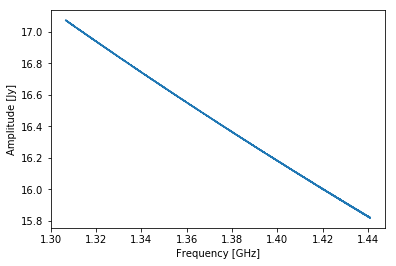

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

freq_avg=np.loadtxt(preflag.basedir+'uvspec_ref.log',float,usecols=[0])
amp_avg=np.loadtxt(preflag.basedir+'uvspec_ref.log',float,usecols=[1])
nchan=len(freq_avg)
plt.plot(freq_avg,amp_avg,'-')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Amplitude [Jy]')
plt.show()

Okay, now let's run uvspec with a shorter averaging interval and save the results to another log file, this time with a timestamp in it.  

In [32]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tint  #Averaging the calibrator over tint.
uvspec.stokes='ii'
uvspec.axis='frequency,amplitude'
uvspec.options='nobase,avall,timelog'
uvspec.log=preflag.basedir+'uvspec_avg.log'

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data/pisano/BP/00/crosscal/3C48.mir',
 'Applying gain corrections to /data/pisano/BP/00/crosscal/3C48.mir']

Okay, now we need to parse this new log file so that we can extract each time interval into a separate array.  To do this, we will use the original extracted spectrum as a guide to the number of channels we need to extract.  

We also need to know the number of intervals, which we can do with the following code:

In [33]:
def lcount(keyword, fname):
    with open(fname, 'r') as fin:
        return sum([1 for line in fin if keyword in line])

In [20]:
nint=lcount(':',preflag.basedir+'uvspec_avg.log')
print("Number of time intervals: ",nint)
print("Number of channels in spectrum: ", nchan)

('Number of time intervals: ', 22)
('Number of channels in spectrum: ', 9348)


We can use grep on the uvspec_avg.log file to extract the exact times corresponding to each interval as well.

We will now use this information to parse the log file, saving each time interval to a separate log.

In [44]:
# First read the entire file into a string list
with open(preflag.basedir+'uvspec_avg.log') as f:
    tmp_text=f.readlines()
f.close()

# Now write out each interval to a separate log file.

times=[]
interval=0
linecount=np.zeros([nint],int)
for t in range(len(tmp_text)-1):
    if ':' in tmp_text[t]:
        if interval!=0:
            f.close()
        f=open(preflag.basedir+"t{}.log".format(str(interval)),"w")
        times.append(tmp_text[t].rstrip())
        interval+=1   
    else:
        linecount[interval-1]+=1
        f.write(tmp_text[t])
f.close()

(22, 9348)
(22, 9348)


Now we will convert the times into MJD to facilitate comparisons and labeling.

In [36]:
from datetime import datetime
from astropy.time import Time
t_mjd=[]
for t in range(len(times)):
    t_mjd.append(Time(datetime.strptime(times[t].rstrip(), '%y%b%d:%H:%M:%S.%f')).mjd)
    
tzero=t_mjd[0]
for t in range(len(t_mjd)):
    t_mjd[t]=(t_mjd[t]-tzero)*24.


Okay, now we create a couple of 2D arrays so we can loop through the log file and save each spectrum to a separate row.  Some time intervals may have all the data for a given channel flagged.  This code will parse the frequencies in order to align channels with each other.  

In [129]:
# Create freq_t and amp_t arrays to hold each time interval in a separate row.  Initially they will be filled with 
# NaNs in case data is flagged in a given channel.
amp_t=np.zeros([nchan,nint],float)
amp_t.fill(np.nan)

# Now load the data from the log file into each row.
for t in range(nint):
    freq=np.loadtxt(preflag.basedir+'t{}.log'.format(str(t)),float,usecols=[0])
    amp=np.loadtxt(preflag.basedir+'t{}.log'.format(str(t)),float,usecols=[1])
    n=np.where(np.isin(freq_avg,freq))[0]
    amp_t[n,t]=amp


Okay, now we can plot these spectra and see how they compare.

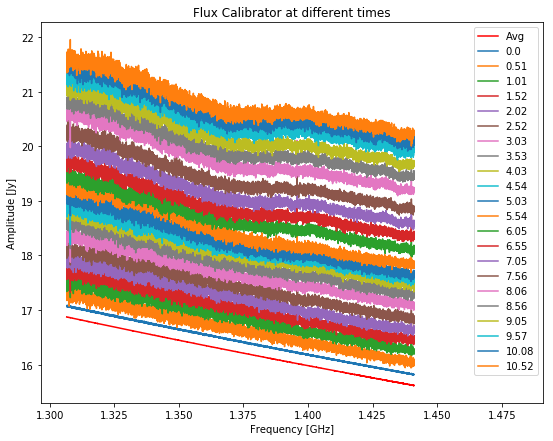

In [255]:
offset=0.2
plt.figure(figsize=(9,7))
plt.plot(freq_avg,amp_avg-offset,'r-',label='Avg')
for t in range(nint):
    plt.plot(freq_avg,amp_t[:,t]+t*offset,'-',label=round(t_mjd[t],2))
plt.xlim(np.min(freq_avg)-0.01,np.max(freq_avg)+0.05)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Amplitude [Jy]')
plt.title('Flux Calibrator at different times')
plt.legend()
plt.show()

Now we will divide each time interval by the average amplitudes and plot those

('Time interval: ', 0, 0.0, 'Mean ratio: ', 0.9999902979713761, '+/-', 0.0002890710763922579)
('Time interval: ', 1, 0.51, 'Mean ratio: ', 1.0009313174423058, '+/-', 0.003072909887277874)
('Time interval: ', 2, 1.01, 'Mean ratio: ', 1.0018072139547214, '+/-', 0.0031795379299299114)
('Time interval: ', 3, 1.52, 'Mean ratio: ', 1.0008210723714406, '+/-', 0.003196785840408427)
('Time interval: ', 4, 2.02, 'Mean ratio: ', 1.000382328037166, '+/-', 0.003365042830800709)
('Time interval: ', 5, 2.52, 'Mean ratio: ', 1.0006073552383725, '+/-', 0.003385589876446293)
('Time interval: ', 6, 3.03, 'Mean ratio: ', 1.0024631944571463, '+/-', 0.003615216610785356)
('Time interval: ', 7, 3.53, 'Mean ratio: ', 1.0024061116526943, '+/-', 0.0039424943813657016)
('Time interval: ', 8, 4.03, 'Mean ratio: ', 1.0010115965365025, '+/-', 0.00411241366831195)
('Time interval: ', 9, 4.54, 'Mean ratio: ', 0.9949849973336296, '+/-', 0.004368325404411538)
('Time interval: ', 10, 5.03, 'Mean ratio: ', 0.989855118081

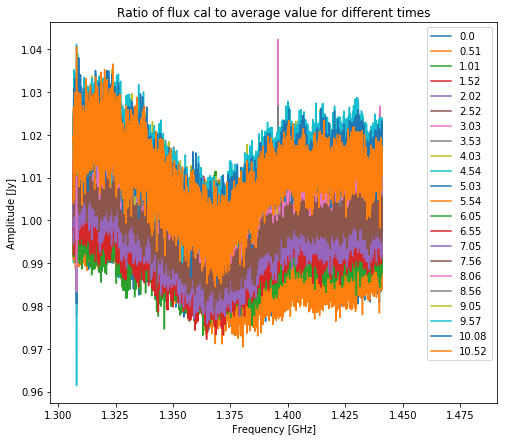

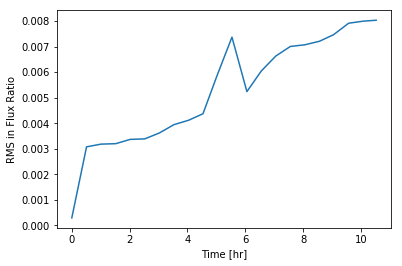

('The RMS of the ratios (averaged over all channels) is: ', 0.007172524075554512)


In [257]:
# Normalize by average amplitude of Flux calibrator to create ratio
amp_r=np.zeros([nchan,nint],float)
amp_r.fill(np.nan)

for t in range(nint):
    amp_r[:,t]=amp_t[:,t]/amp_avg[:]

# Calculate mean and stdev for each time interval
avg=[]
unc=[]
for t in range(nint):
    avg.append(np.nanmean(amp_r[:,t]))
    unc.append(np.nanstd(amp_r[:,t]))    
    print("Time interval: ",t,round(t_mjd[t],2),"Mean ratio: ",avg[t],'+/-',unc[t])
    
# Plot each time interval
plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_avg,amp_r[:,t],label=round(t_mjd[t],2))
plt.xlim(np.min(freq_avg)-0.01,np.max(freq_avg)+0.05)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Amplitude [Jy]')
plt.legend()
plt.title('Ratio of flux cal to average value for different times')
plt.show()

plt.plot(t_mjd, unc)
plt.xlabel("Time [hr]")
plt.ylabel("RMS in Flux Ratio")
plt.show()

print("The RMS of the ratios (averaged over all channels) is: ",np.std(avg))

Finally, clean up scratch log files.

In [132]:
import subprocess
os.system('rm -f'+preflag.basedir+'t*.log')
#os.listdir('/data/{0}/BP/'.format(myusername))

256

### This section will look at various tests of BP Stability

For starters, we are going to do some iterative smoothing of the BP spectrum ratio.  All smoothing will be done without decimation, and will either factor into a single 64 channel subband, or be multiples of a subband.  For starters, we will do 2, 4, 8, 16, 32, 64, 128, 256, 512 channels.

[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0]


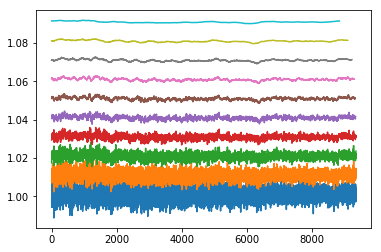

[0.00307291 0.00219143 0.00157493 0.00115318 0.0008817  0.00071174
 0.00060625 0.00052797 0.00045896 0.00038071]


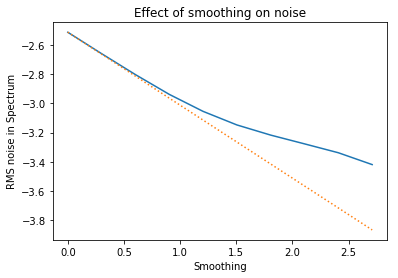

In [184]:
# Specify Smoothing factor
nsmooth=10 # Number of smooth iterations
skern=[]  # Define smoothing kernel


for i in range(0,nsmooth):
    skern.append(2.**i)
print(skern)
# Just going to look at this for the last chunk of time.
rms_time=np.zeros(nsmooth,float)
rms_theory=np.zeros(nsmooth,float)

useint=1  # Should be between 0 and nint
for s in range(nsmooth):
    kern=np.ones(int(skern[s]),float)/skern[s]
    amp_s=np.convolve(amp_r[:,useint],kern,'valid')
    rms_time[s]=np.nanstd(amp_s)
    plt.plot(amp_s+s/100.)
    if s==0:
        rms_theory[s]=rms_time[s]
    else:
        rms_theory[s]=rms_theory[0]/np.sqrt(skern[s])

plt.show()

print(rms_time)
plt.plot(np.log10(skern),np.log10(rms_time))
plt.plot(np.log10(skern),np.log10(rms_theory),':')
plt.xlabel('Smoothing')
plt.ylabel('RMS noise in Spectrum')
plt.title('Effect of smoothing on noise')
plt.show()

### Dividing the Spectrum into ~ 10 MHz chunks

Okay, the bandpass stability specification is that there is less than a 1:10$^4$ variation across a 10 MHz frequency chunk over 12 hours.  To test this directly, we will average the spectrum over 768 channels (approx. 9.3 MHz; 12 frequency chunks)

In [210]:
df=12.20703125 # Channel width in kHz from a data cube
chanchunk=768 # Sticking with multiples of the subbands (64 channels), this is ~9.4 MHz
chunk_freq=df*chanchunk
nchunk=int(nchan/chanchunk)
print(nchunk,chunk_freq/1000.)

freq_bin=np.zeros(nchunk,float)
ratio_bin=np.zeros([nchunk,nint],float)
rms_bin=np.zeros([nchunk,nint],float)

# Now we will derive the average frequency and average ratio for each 10 MHz chunk
c1=0
c2=chanchunk
for i in range(nchunk):
    freq_bin[i]=np.nanmean(freq_avg[c1:c2])
    for t in range(nint):
        ratio_bin[i,t]=np.nanmean(amp_r[c1:c2,t])
        rms_bin[i,t]=np.nanstd(amp_r[c1:c2,t])
    c1+=chanchunk
    c2+=chanchunk

(12, 9.375)


Okay, let's look at the ratio as a function of both frequency and time:

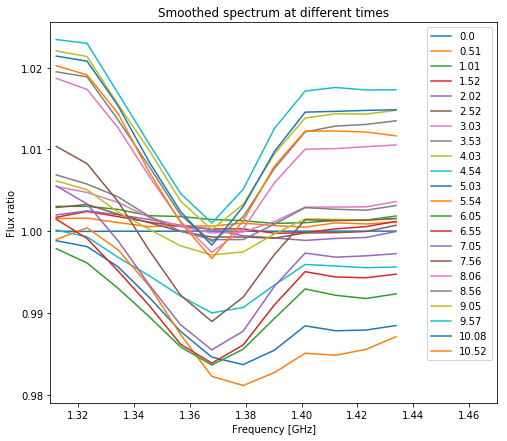

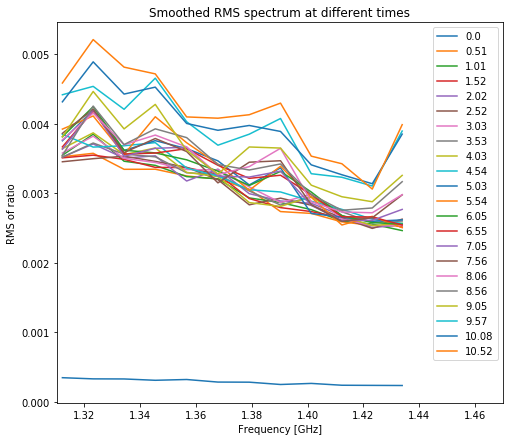

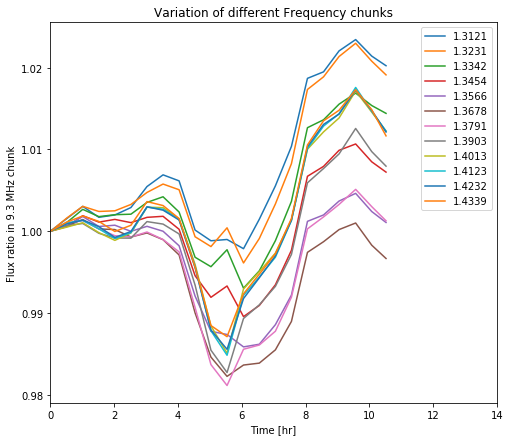

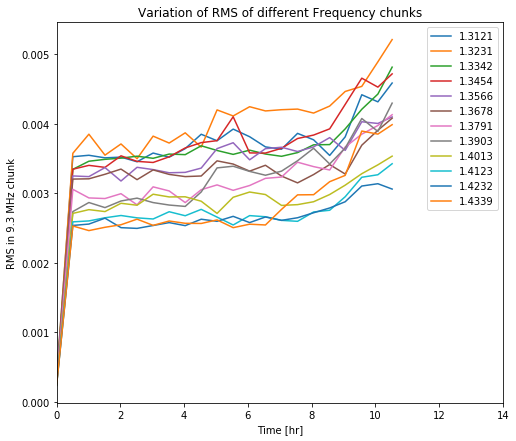

In [263]:
plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,ratio_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Flux ratio')
plt.title('Smoothed spectrum at different times')
plt.xlim(1.31,1.47)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,rms_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('RMS of ratio')
plt.title('Smoothed RMS spectrum at different times')
plt.xlim(1.31,1.47)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,ratio_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('Flux ratio in 9.3 MHz chunk')
plt.xlim(0.,14.)
plt.title('Variation of different Frequency chunks')
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,rms_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('RMS in 9.3 MHz chunk')
plt.title('Variation of RMS of different Frequency chunks')
plt.xlim(0.,14.)
plt.legend()
plt.show()

In [219]:
# Calculate the RMS variation with time of each 10 MHz chunk
rms=[]
for c in range(nchunk):
    rms.append(np.std(ratio_bin[c,:]))
    print('RMS variation of ratio in frequency chunk ',c,' is ',rms[c])

print('Mean RMS is ',np.mean(rms))
print('The fraction of the goal (1:10000) is: ',np.mean(rms)/1e-4)

('RMS variation of ratio in frequency chunk ', 0, ' is ', 0.008626711270359426)
('RMS variation of ratio in frequency chunk ', 1, ' is ', 0.008485824585930724)
('RMS variation of ratio in frequency chunk ', 2, ' is ', 0.007175163771609237)
('RMS variation of ratio in frequency chunk ', 3, ' is ', 0.0061497188848051694)
('RMS variation of ratio in frequency chunk ', 4, ' is ', 0.006156670021925513)
('RMS variation of ratio in frequency chunk ', 5, ' is ', 0.006697552583140372)
('RMS variation of ratio in frequency chunk ', 6, ' is ', 0.007043902520492019)
('RMS variation of ratio in frequency chunk ', 7, ' is ', 0.007685710232879323)
('RMS variation of ratio in frequency chunk ', 8, ' is ', 0.008226322276394546)
('RMS variation of ratio in frequency chunk ', 9, ' is ', 0.008488202770800896)
('RMS variation of ratio in frequency chunk ', 10, ' is ', 0.008432338451909542)
('RMS variation of ratio in frequency chunk ', 11, ' is ', 0.00822530296351349)
('Mean RMS is ', 0.007616118361146688)

### Phase Stability Checks

Now that we have looked at amplitude stability, we should do a similar comparison for phases.  This comparison should be done by looking at offsets, however, and not fractional changes.  Otherwise the results should be the same.

In [223]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tsolve  #Averaging the calibrator over tsolve.
uvspec.stokes='ii'
uvspec.axis='frequency,phase'
uvspec.options='nobase,avall'
uvspec.select=tcal
uvspec.log=preflag.basedir+'uvspec_12h_phase.log'

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data/pisano/BP/00/crosscal/3C48.mir',
 'Applying gain corrections to /data/pisano/BP/00/crosscal/3C48.mir']

Now we will load the average bandpass into an array, plot it, and save it for reference. 

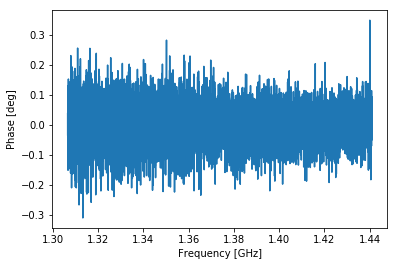

In [224]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

freq_avg=np.loadtxt(preflag.basedir+'uvspec_12h_phase.log',float,usecols=[0])
ph_avg=np.loadtxt(preflag.basedir+'uvspec_12h_phase.log',float,usecols=[1])
nchan=len(freq_avg)
plt.plot(freq_avg,ph_avg,'-')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase [deg]')
plt.show()

Okay, now let's run uvspec with a shorter averaging interval and save the results to another log file, this time with a timestamp in it.  

In [225]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tint  #Averaging the calibrator over tint.
uvspec.stokes='ii'
uvspec.axis='frequency,phase'
uvspec.options='nobase,avall,timelog'
uvspec.log=preflag.basedir+'uvspec_avg_phase.log'

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data/pisano/BP/00/crosscal/3C48.mir',
 'Applying gain corrections to /data/pisano/BP/00/crosscal/3C48.mir']

In [226]:
# First read the entire file into a string list
with open(preflag.basedir+'uvspec_avg_phase.log') as f:
    tmp_text=f.readlines()
f.close()

# Now write out each interval to a separate log file.

times=[]
interval=0
linecount=np.zeros([nint],int)
for t in range(len(tmp_text)-1):
    if ':' in tmp_text[t]:
        if interval!=0:
            f.close()
        f=open(preflag.basedir+"t{}.log".format(str(interval)),"w")
        times.append(tmp_text[t].rstrip())
        interval+=1   
    else:
        linecount[interval-1]+=1
        f.write(tmp_text[t])
f.close()

In [229]:
# Create freq_t and amp_t arrays to hold each time interval in a separate row.  Initially they will be filled with 
# zeros.
ph_t=np.zeros([nchan,nint],float)
ph_t.fill(np.nan)

# Now load the data from the log file into each row.
for t in range(nint):
    freq=np.loadtxt(preflag.basedir+'t{}.log'.format(str(t)),float,usecols=[0])
    ph=np.loadtxt(preflag.basedir+'t{}.log'.format(str(t)),float,usecols=[1])
    n=np.where(np.isin(freq_avg,freq))[0]
    ph_t[n,t]=ph


Okay, now we can plot these spectra and see how they compare.

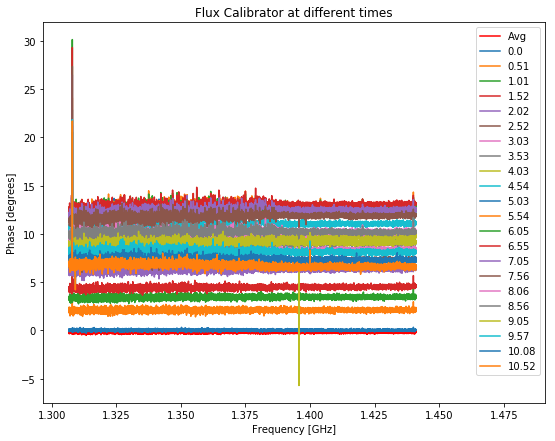

In [264]:
plt.figure(figsize=(9,7))
offset=0.2
plt.plot(freq_avg,ph_avg-offset,'r-',label='Avg')
for t in range(nint):
    plt.plot(freq_avg,ph_t[:,t]+t*offset,'-',label=round(t_mjd[t],2))
plt.xlim(np.min(freq_avg)-0.01,np.max(freq_t[:,0])+0.05)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase [degrees]')
plt.title('Flux Calibrator at different times')
plt.legend()
plt.show()

Now we will subtract the mean phases from each interval and plot that difference.

('Time interval: ', 0, 0.0, 'Mean phase difference: ', 0.030675876954466427, '+/-', 0.015981229130744505)
('Time interval: ', 1, 0.51, 'Mean phase difference: ', 1.9052419463387877, '+/-', 0.17513673159760107)
('Time interval: ', 2, 1.01, 'Mean phase difference: ', 3.0522326668779405, '+/-', 0.18705180801983715)
('Time interval: ', 3, 1.52, 'Mean phase difference: ', 3.8540665010349793, '+/-', 0.20111734540479123)
('Time interval: ', 4, 2.02, 'Mean phase difference: ', 5.486814247964803, '+/-', 0.22917001317765728)
('Time interval: ', 5, 2.52, 'Mean phase difference: ', 6.234847022675972, '+/-', 0.2420755763725708)
('Time interval: ', 6, 3.03, 'Mean phase difference: ', 7.082158653827021, '+/-', 0.26494888327719734)
('Time interval: ', 7, 3.53, 'Mean phase difference: ', 7.5739679934718644, '+/-', 0.27761620011943383)
('Time interval: ', 8, 4.03, 'Mean phase difference: ', 7.938535614460311, '+/-', 0.29480510481336947)
('Time interval: ', 9, 4.54, 'Mean phase difference: ', 9.135447480

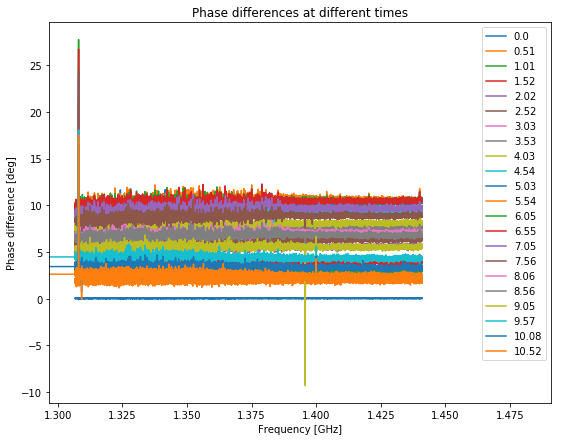

('The RMS of the phase differences (averaged over all channels) is: ', 3.0064986409074264)


In [266]:
# Normalize by average amplitude of Flux calibrator to create ratio
ph_r=np.zeros([nchan,nint],float)
ph_r.fill(np.nan)

for t in range(nint):
    ph_r[:,t]=ph_t[:,t]-ph_avg[:]

# Calculate mean and stdev for each time interval
avg=[]
unc=[]
for t in range(nint):
    avg.append(np.nanmean(ph_r[:,t]))
    unc.append(np.nanstd(ph_r[:,t]))    
    print("Time interval: ",t,round(t_mjd[t],2),"Mean phase difference: ",avg[t],'+/-',unc[t])
    
# Plot each time interval
plt.figure(figsize=(9,7))
for t in range(nint):
    plt.plot(freq_t[:,t],ph_r[:,t],label=round(t_mjd[t],2))
plt.xlim(np.min(freq_t[:,0])-0.01,np.max(freq_t[:,0])+0.05)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase difference [deg]')
plt.legend()
plt.title('Phase differences at different times')
plt.show()

print("The RMS of the phase differences (averaged over all channels) is: ",np.std(avg))

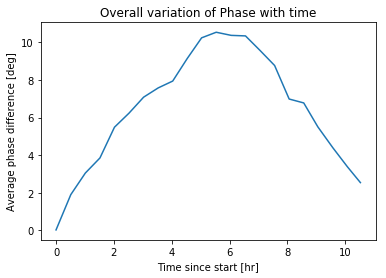

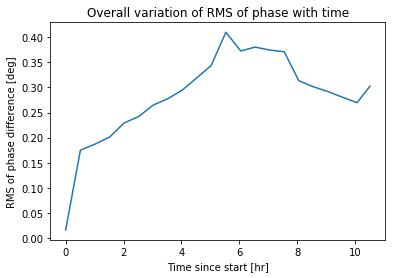

In [267]:
# Plot evolution of average phase difference and average rms with time
plt.plot(t_mjd,avg)
plt.xlabel('Time since start [hr]')
plt.ylabel('Average phase difference [deg]')
plt.title('Overall variation of Phase with time')
plt.show()

plt.plot(t_mjd,unc)
plt.xlabel('Time since start [hr]')
plt.ylabel('RMS of phase difference [deg]')
plt.title('Overall variation of RMS of phase with time')
plt.show()

In [240]:
# Divide the phases into the same chunks as the amplitudes

ph_ratio_bin=np.zeros([nchunk,nint],float)
ph_rms_bin=np.zeros([nchunk,nint],float)
# Now we will derive the average frequency and average ratio for each 9.3 MHz chunk
c1=0
c2=chanchunk
for i in range(nchunk):
    for t in range(nint):
        ph_ratio_bin[i,t]=np.nanmean(ph_r[c1:c2,t])
        ph_rms_bin[i,t]=np.nanstd(ph_r[c1:c2,t])

    c1+=chanchunk
    c2+=chanchunk

Okay, let's look at the phase difference as a function of both frequency and time:

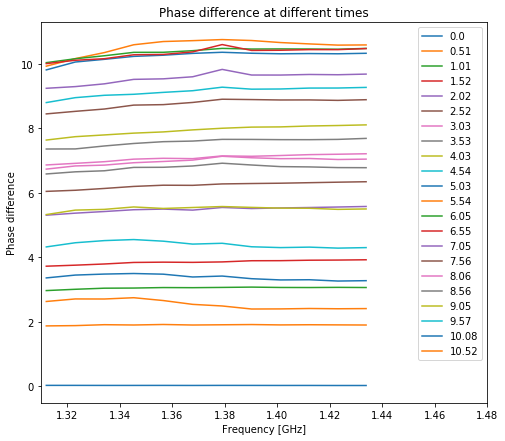

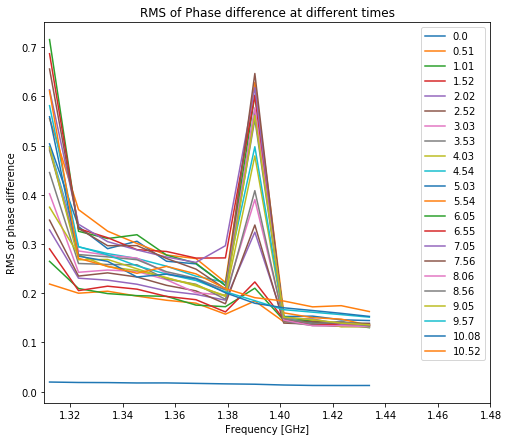

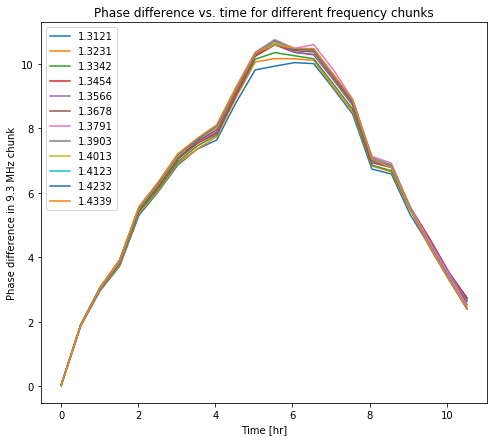

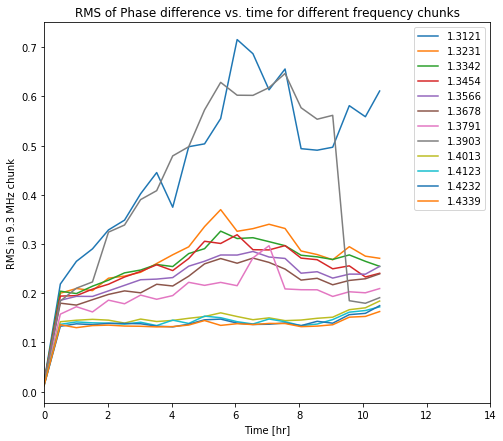

In [269]:
plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,ph_ratio_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase difference')
plt.title('Phase difference at different times')
plt.xlim(1.31,1.48)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,ph_rms_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('RMS of phase difference')
plt.title('Phase spectrum at different times')
plt.title('RMS of Phase difference at different times')
plt.xlim(1.31,1.48)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,ph_ratio_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('Phase difference in 9.3 MHz chunk')
plt.title('Phase difference vs. time for different frequency chunks')
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,ph_rms_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('RMS in 9.3 MHz chunk')
plt.title('RMS of Phase difference vs. time for different frequency chunks')
plt.xlim(0.,14.)
plt.legend()
plt.show()

In [244]:
# Calculate the RMS variation with time of each 10 MHz chunk
rms=[]
for c in range(nchunk):
    rms.append(np.std(ph_ratio_bin[c,:]))
    print('RMS variation of ratio in frequency chunk ',c,' is ',rms[c])

print('Mean RMS is ',np.mean(rms))


('RMS variation of ratio in frequency chunk ', 0, ' is ', 2.8654449453659785)
('RMS variation of ratio in frequency chunk ', 1, ' is ', 2.903135332731716)
('RMS variation of ratio in frequency chunk ', 2, ' is ', 2.9314139555728156)
('RMS variation of ratio in frequency chunk ', 3, ' is ', 2.97408111607348)
('RMS variation of ratio in frequency chunk ', 4, ' is ', 2.994596298304242)
('RMS variation of ratio in frequency chunk ', 5, ' is ', 3.0321607709005813)
('RMS variation of ratio in frequency chunk ', 6, ' is ', 3.0744297278445933)
('RMS variation of ratio in frequency chunk ', 7, ' is ', 3.0589959997257985)
('RMS variation of ratio in frequency chunk ', 8, ' is ', 3.058017741211508)
('RMS variation of ratio in frequency chunk ', 9, ' is ', 3.0572649372026546)
('RMS variation of ratio in frequency chunk ', 10, ' is ', 3.0572747552578208)
('RMS variation of ratio in frequency chunk ', 11, ' is ', 3.0640050544288653)
('Mean RMS is ', 3.0059017195516713)
